In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as sio
from scipy import signal
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Load data

In [2]:
Salinas_corrected = sio.loadmat('./Salinas_corrected.mat')
Salinas_gt = sio.loadmat('./Salinas_gt.mat')
print(Salinas_corrected.keys())
print(Salinas_gt.keys())

dict_keys(['__header__', '__version__', '__globals__', 'salinas_corrected'])
dict_keys(['__header__', '__version__', '__globals__', 'salinas_gt'])


In [3]:
salinas_img = Salinas_corrected['salinas_corrected']
salinas_labels = Salinas_gt['salinas_gt']
salinas_img = salinas_img / salinas_img.max()
print("Salinas shape: {}".format(salinas_img.shape))

Salinas shape: (512, 217, 204)


Text(0.5, 1.0, 'Salinas labels')

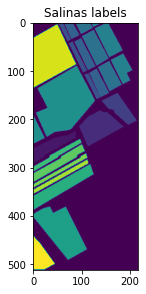

In [4]:
# Display ground truth for each image
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.imshow(salinas_labels, cmap='viridis')
plt.title('Salinas labels')

# Plot the curve of one sample

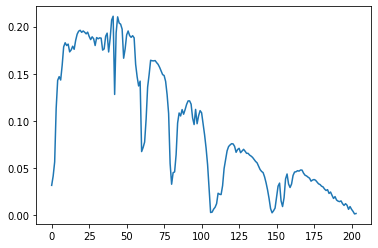

In [5]:
# get any position 
pos = [0,1]
feature = salinas_img[pos[0],pos[1],:]
plt.plot(feature)

# Data count of each class

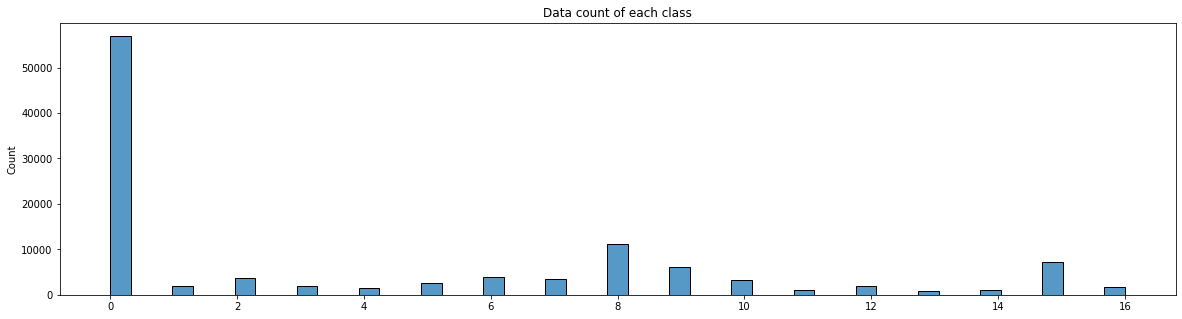

In [6]:
plt.figure(figsize=(20,5))
ax_salinas = sns.histplot(salinas_labels.flatten())
plt.title("Data count of each class")
plt.show()

# Reshape the data

In [7]:
X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1])) # reshaping the HSI as a 2D matrix
y_gt = salinas_labels.ravel()
print("Salinas shape: {}".format(X_salinas.shape))

Salinas shape: (111104, 204)


In [8]:
n_classes_salinas = len(np.unique(salinas_labels)) - 1
print("Number of labels Salinas: {}".format(n_classes_salinas))

Number of labels Salinas: 16


# Remove the background

In [9]:
X_salinas = np.delete(X_salinas, np.where(y_gt == 0), axis = 0)
y = np.delete(y_gt, np.where(y_gt == 0))

In [10]:
print(X_salinas.shape)
print(y.shape)

(54129, 204)
(54129,)


# PCA

In [11]:
#this function is from "tools.py" in "https://github.com/drguigui1/HSI-Classification/blob/7702cd8266853165ff7e62e36fc2d907846c7269/src/7%20-%20Random_forest_classifier.ipynb"
print("Fitting the PCA")
pca_model = PCA()
pca_model.fit(X_salinas)
var_cumsum = pca_model.explained_variance_ratio_.cumsum()
num_useful_feature = len(var_cumsum[var_cumsum <= 0.997])
print("Number of components Salinas:")
print(num_useful_feature) 

Fitting the PCA
Number of components Salinas:
3


In [12]:
pca_model = PCA(n_components = num_useful_feature)
pca_model.fit(X_salinas)
X_salinas_reduced_pca = pca_model.transform(X_salinas)
print(X_salinas_reduced_pca.shape)

(54129, 3)


# Rescale the data into range (0,1)

In [13]:
# setup the MinMaxScaler 
scaler = MinMaxScaler(feature_range=(0, 1))
# Normalization: transform the dataset into the range [0,1]
X_salinas_01 = scaler.fit_transform(X_salinas_reduced_pca)
#salinas_img_scaled = X_salinas_01.reshape(salinas_img.shape[0], salinas_img.shape[1], salinas_img.shape[2])

In [14]:
print(X_salinas_01.mean())
print(X_salinas_01.var())

0.43229469827855954
0.030926530349598802


The first graph shows the variance ratio of features(PCA) and the second graph is the cumulative sum of variance ratio

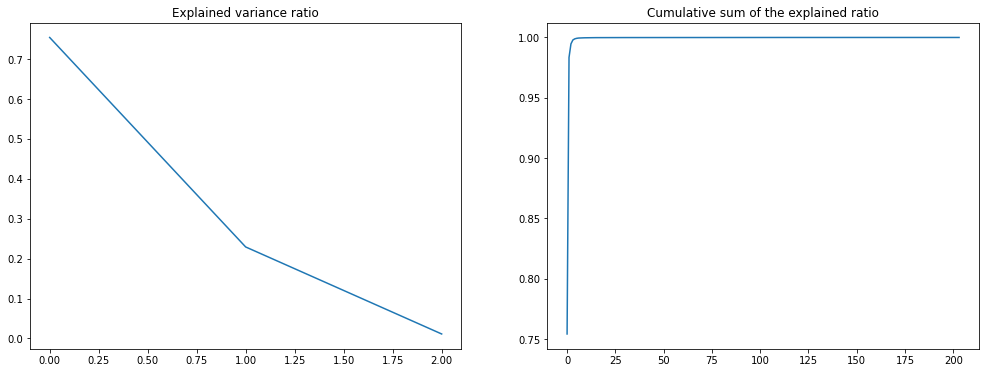

In [15]:
#this function is from "notebook.py" from https://notebooks.githubusercontent.com/view/ipynb?browser=edge&color_mode=auto&commit=fae244fbe6dd08dc1a4d336dc326b05a84429197&device=unknown_device&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f4c69306e4d6f3073652f6879706572737065637472616c5f696d6c2f666165323434666265366464303864633161346433333664633332366230356138343432393139372f50726f6a6563742e6970796e62&logged_in=true&nwo=Li0nMo0se%2Fhyperspectral_iml&path=Project.ipynb&platform=windows&repository_id=360174211&repository_type=Repository&version=96#load-data
plt.figure(figsize=(17,6))
plt.subplot(1, 2, 1)
plt.plot(pca_model.explained_variance_ratio_[:10])
plt.title("Explained variance ratio")

plt.subplot(1, 2, 2)
plt.title("Cumulative sum of the explained ratio")
plt.plot(var_cumsum)
plt.show()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_salinas_01, y, test_size=0.25, random_state=42)

In [17]:
print("Train shape: {}".format(X_train.shape))
print("Train labels shape: {}".format(y_train.shape))
print("Test shape: {}".format(X_test.shape))
print("Test labels shape: {}".format(y_test.shape))

Train shape: (40596, 3)
Train labels shape: (40596,)
Test shape: (13533, 3)
Test labels shape: (13533,)


# KNN Classification

In [18]:
#Model instantiation
modelKNN_salinas = KNeighborsClassifier()

In [19]:
#Set the number of feature (PCA)
param_n_components = [num_useful_feature]
print(param_n_components)

[3]


In [20]:
#Make sure the steps of the transformation sequence
pipe_knn_salinas = Pipeline(steps=[('pca', pca_model),
                                   ('knn', modelKNN_salinas)])

In [21]:
#this function is from "notebook.py" from https://notebooks.githubusercontent.com/view/ipynb?browser=edge&color_mode=auto&commit=fae244fbe6dd08dc1a4d336dc326b05a84429197&device=unknown_device&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f4c69306e4d6f3073652f6879706572737065637472616c5f696d6c2f666165323434666265366464303864633161346433333664633332366230356138343432393139372f50726f6a6563742e6970796e62&logged_in=true&nwo=Li0nMo0se%2Fhyperspectral_iml&path=Project.ipynb&platform=windows&repository_id=360174211&repository_type=Repository&version=96#load-data
grid_params = {
    'knn__n_neighbors' : [3,4,5],
    'knn__weights' : ['distance', 'uniform'],
    'knn__algorithm' : ['ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [10, 30],
    'pca__n_components': param_n_components,
}

In "GridSearchCV()", the k-fold method is used, since the default value of the parameter "cv" is 5, the 5-fold method is used to divide part of the training data into validation data to evaluate the training effect of the model and select the parameters.

In [22]:
#this function is from "notebook.py" from https://notebooks.githubusercontent.com/view/ipynb?browser=edge&color_mode=auto&commit=fae244fbe6dd08dc1a4d336dc326b05a84429197&device=unknown_device&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f4c69306e4d6f3073652f6879706572737065637472616c5f696d6c2f666165323434666265366464303864633161346433333664633332366230356138343432393139372f50726f6a6563742e6970796e62&logged_in=true&nwo=Li0nMo0se%2Fhyperspectral_iml&path=Project.ipynb&platform=windows&repository_id=360174211&repository_type=Repository&version=96#load-data
from sklearn.model_selection import GridSearchCV

# / Positional argument before
# * Must name the parameter
def grid_search(clf, X, y, grid_params, /, *, n_jobs=8, verbose=4):
    # Create the gridsearch
    # Cross validation gridsearch
    gs = GridSearchCV(clf, grid_params, n_jobs=8, verbose=4)
    print("---- Start search ----")
    gs.fit(X, y)
    print("---- Search finished ----")
    print("Best parameter (CV score=%0.3f): " % gs.best_score_)
    print(gs.best_params_)
    return gs.best_params_

In [23]:
best_params = grid_search(pipe_knn_salinas, X_train, y_train, grid_params)

---- Start search ----
Fitting 5 folds for each of 36 candidates, totalling 180 fits
---- Search finished ----
Best parameter (CV score=0.907): 
{'knn__algorithm': 'ball_tree', 'knn__leaf_size': 10, 'knn__n_neighbors': 5, 'knn__weights': 'distance', 'pca__n_components': 3}


In [24]:
%%time
scores = cross_val_score(modelKNN_salinas, X_train, y_train, cv=5)

Wall time: 1.52 s


In [25]:
print(scores)
print("The average score is {}".format(np.mean(scores)))

[0.88608374 0.89382929 0.8876709  0.8914891  0.89235127]
The average score is 0.8902848606049061


In [26]:
#Fit the model
modelKNN_salinas.fit(X_train, y_train)

KNeighborsClassifier()

In [27]:
%%time
modelKNN_salinas.verbose=0
preds_salinas_test = modelKNN_salinas.predict(X_test)
salinas_test_score = accuracy_score(y_test, preds_salinas_test)
print("Salinas training score {} and testing {}".format(np.mean(scores), salinas_test_score))

Salinas training score 0.8902848606049061 and testing 0.8898987659794576
Wall time: 436 ms


The comparison histogram of predicted labels and expected labels

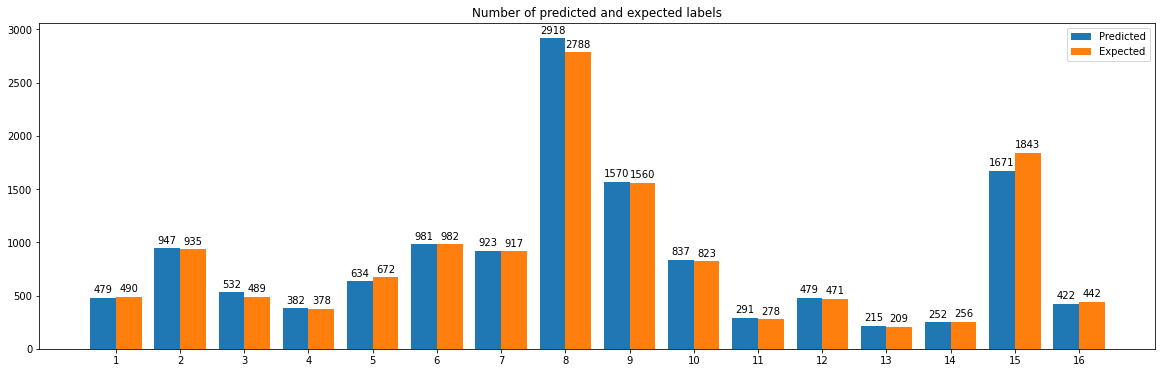

In [28]:
#this function is from "plot.py" in "https://github.com/drguigui1/HSI-Classification/blob/7702cd8266853165ff7e62e36fc2d907846c7269/src/7%20-%20Random_forest_classifier.ipynb"
fig, axs = plt.subplots(figsize=(20, 6))

bar_x, bar_count_pred = np.unique(preds_salinas_test, return_counts=True)
bar1 = axs.bar(bar_x - 1.2, bar_count_pred, 0.4, label="Predicted")

bar_x, bar_count_exp = np.unique(y_test, return_counts=True)
bar2 = axs.bar(bar_x - 0.8, bar_count_exp, 0.4, label="Expected")

title='Number of predicted and expected labels'

axs.bar_label(bar1, padding=3)
axs.bar_label(bar2, padding=3)

axs.set_xticks(np.arange(len(bar_x)))
axs.set_xticklabels(bar_x)

axs.set_title(title)
axs.legend()
plt.show()

Predict the total data

In [29]:
%%time
total_preds_salinas = modelKNN_salinas.predict(X_salinas_01)

Wall time: 1.51 s


Final performance of this model

In [30]:
#accuracy
total_preds_salinas_score = accuracy_score(y, total_preds_salinas)
print("The final accuracy of this model is {}".format(total_preds_salinas_score))

The final accuracy of this model is 0.9156829056513145


In [31]:
#mean square error
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y, total_preds_salinas))

3.6148275416135527


In [32]:
#precision,recall,f1-score
from sklearn.metrics import classification_report
print(classification_report(y, total_preds_salinas))

              precision    recall  f1-score   support

           1       1.00      0.99      0.99      2009
           2       0.99      1.00      1.00      3726
           3       0.93      0.98      0.96      1976
           4       0.99      0.99      0.99      1394
           5       0.98      0.95      0.96      2678
           6       1.00      1.00      1.00      3959
           7       0.99      0.99      0.99      3579
           8       0.81      0.85      0.83     11271
           9       0.99      0.99      0.99      6203
          10       0.93      0.93      0.93      3278
          11       0.93      0.97      0.95      1068
          12       0.98      1.00      0.99      1927
          13       0.97      0.99      0.98       916
          14       0.98      0.96      0.97      1070
          15       0.76      0.71      0.73      7268
          16       0.98      0.95      0.96      1807

    accuracy                           0.92     54129
   macro avg       0.95   

# Result visualization

In [33]:
idx = np.argwhere(salinas_labels.flatten() != 0).flatten()

In [34]:
salinas_preds_img = np.zeros((salinas_img.shape[0] * salinas_img.shape[1]))
salinas_preds_img[idx] = total_preds_salinas
salinas_preds_img = salinas_preds_img.reshape(((salinas_img.shape[0], salinas_img.shape[1])))

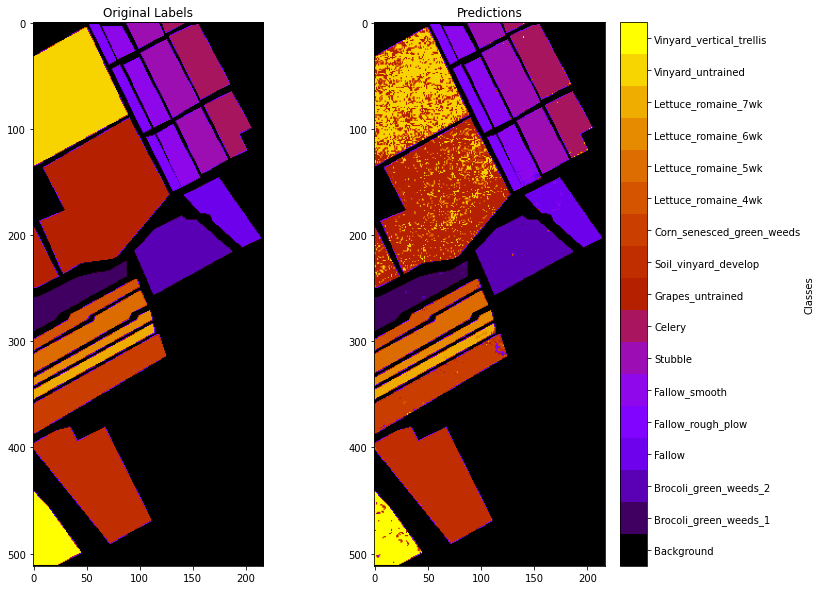

In [35]:
global GROUND_TRUTH
global NUM_CLASSES
#Establish the name of labels
GROUND_TRUTH = ['Background', 'Brocoli_green_weeds_1', 'Brocoli_green_weeds_2', 'Fallow', 'Fallow_rough_plow',
                        'Fallow_smooth', 'Stubble', 'Celery', 'Grapes_untrained', 'Soil_vinyard_develop',
                        'Corn_senesced_green_weeds', 'Lettuce_romaine_4wk', 'Lettuce_romaine_5wk',
                        'Lettuce_romaine_6wk', 'Lettuce_romaine_7wk', 'Vinyard_untrained', 'Vinyard_vertical_trellis']
NUM_CLASSES = len(GROUND_TRUTH) - 1

plt.figure(figsize=(12,10))

plt.subplot(1, 2, 1)
plt.title('Original Labels')
plt.imshow(salinas_labels,cmap='gnuplot')

plt.subplot(1, 2, 2)
plt.title('Predictions')
plt.imshow(salinas_preds_img,cmap='gnuplot')

cbar = plt.colorbar(label='Classes', boundaries=(np.arange(NUM_CLASSES + 2) - 0.5))
cbar.set_ticks(np.arange(NUM_CLASSES + 1))
cbar.set_ticklabels(GROUND_TRUTH)
plt.show()